We start by adding the necessary folders to the current working path.

In [1]:
# import sys
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticLagrangianDiffusionBarriers folder to current working path
sys.path.append(parent_directory+"/demos/DiffusionBarriers/EllipticLagrangianDiffusionBarriers")

# Overview

In the following notebok we extract elliptic Lagrangian diffusion barriers in the Agulhas region from the AVISO dataset using the null geodesic identification scheme. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data/AVISO'
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Elliptic Lagrangian diffusion barriers:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary meshgrid. 
    <br />
    * Compute time-averaged diffusion Cauchy Green strain tensor as: 
    
    \begin{equation} \mathbf{\overline{C}_D}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \int_{t_0}^{t_N}[\mathbf{C}_D]_{t_0}^{t_N} dt = \dfrac{1}{t_N-t_0} \int_{t_0}^{t_N} det[\mathbf{D}(\mathbf{F}_{t_0}^t(\mathbf{x}_0), t)][\mathbf{T}_{t_0}^t(\mathbf{x}_0)]^{-1} dt, \end{equation} where $ \mathbf{T}_{t_0}^t(\mathbf{x}_0) = [\mathbf{\nabla_0 F_{t_0}^t}(\mathbf{x}_0)]^{-1}\mathbf{D}(\mathbf{F}_{t_0}^t(\mathbf{x}_0), t)\mathbf{\nabla_0 F_{t_0}^t}(\mathbf{x}_0)]^{-T} $ 
    <br />
    * Compute eigenvectors $ \xi_{1,2}(\mathbf{x}_0) $ of the Cauchy Green strain tensor $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $.
    <br />
    * Uniform transport barriers and enhancers satisfy
    
    \begin{equation}
    \langle \mathbf{x}_0', (\mathbf{\overline{C}_D}_{t_0}^{t_N}(\mathbf{x}_0)- \mathcal{T}_0 \mathbf{I})
    \mathbf{x}_0') = 0
    \end{equation}
    
    These are precisely null-geodesics of:
    
    \begin{equation}
    \mathbf{\hat{E}}_{\mathcal{T}_0}(\mathbf{x}_0) = \mathbf{\overline{C}}_d(\mathbf{x}_0)-
    \mathcal{T}_0\mathbf{I},
    \end{equation} on the spatial domain satisfying $ \overline{\lambda}_1 \leq \mathcal{T}_0 \leq
    \overline{\lambda}_2 $
    
    Elliptic Lagrangian diffusion barriers are closed null geodesics of the one-parameter family of Lorentzian
    metrics $ \mathrm{\overline{C}_{D}}_{t_0}^{t_N}(\mathbf{x}_0) − \mathcal{T}_0 I $. $ \mathcal{T}_0 $ equals to the uniform diffusive transport density across any material surface over the time-interval $
    [t_0, t_N] $.
    
    Elliptic Lagrangian diffusion barrierss are closed null geodesics of the one-parameter family of Lorentzian
    metrics:
    
    \begin{equation}
    \mathrm{A_{\mathcal{T}_0}(\mathbf{x}_0,t)} = \mathbf{\overline{C}_D}_{t_0}^{t_N}(\mathbf{x}_0) - \mathcal{T}_0\mathbf{I}
    \end{equation}
    
    We denote:
    \begin{equation}
    \mathbf{\overline{C}_D}_{t_0}^{t_N}(\mathbf{x}_0) = \begin{pmatrix} C_D^{11} && C_D^{12} \\ C_D^{12} && C_D^{22}\end{pmatrix}
    \end{equation}
    
    Closed null geodesics are closed curves of the system of ODE:
    
    \begin{align}
    \dfrac{d \mathbf{x}}{ds} &= \mathbf{e}_{\phi}(s) = \begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix} \\
    \dfrac{d \phi}{ds} &= - \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A(\mathbf{x}) \mathbf{e}_{\phi}(s)}, \label{eq: RHS}
    \end{align} where $ R = \begin{pmatrix} 0 && -1 \\ 1 && 0\end{pmatrix} $.
    
    $  \dfrac{d \phi}{ds} $ depends both on $ \mathbf{x} $ and on $ \phi $ and can be evaluated through interpolation by first computing $ \nabla_x \mathbf{A}(\mathbf{x}) = \nabla_x \mathbf{\overline{C}_D}_{t_0}^{t_N}(\mathbf{x}) $ over the meshgrid. 
    
    It holds:
    \begin{equation}
    \dfrac{d \phi}{ds} = - \dfrac{\cos^2(\phi)[{C_D}_x^{11}(\mathbf{x})\cos(\phi)+{C_D}_y^{11}(\mathbf{x})\sin(\phi)]+[{C_D}_x^{12}(\mathbf{x})\cos(\phi)+{C_D}_y^{11}(\mathbf{x})\sin(\phi)]\sin(2\phi)+\sin^2(\phi)[{C_D}_x^{22}(\mathbf{x})\cos(\phi)+{C_D}_y^{22}(\mathbf{x})\sin(\phi)}{\sin(2\phi)[C_D^{22}(\mathbf{x})-C_D^{11}(\mathbf{x})]+2\cos(2\phi)C_D^{12}(\mathbf{x})}
    \end{equation}
    
    The set of initial conditions is given by:
    \begin{equation}
    (\mathbf{x}_0, \phi_0)_{\mathcal{T}_0} = \lbrace (\mathbf{x}_0(\mathcal{T}_0, \phi = 0), 0) \in V: C_D^{11}(\mathbf{x}, t)- \mathcal{T}_0 = 0 \rbrace
    \end{equation}
    
    Furthermore the domain of existence of the ODE is restricted to points $ \mathbf{x}, \phi $ where:
    
    \begin{equation}
    \sin(2\phi)[C_D^{22}(\mathbf{x})-C_D^{11}(\mathbf{x})]+2\cos(2\phi)C_D^{12}(\mathbf{x}) \neq 0
    \end{equation}
    
    In order to be evaluate the RHS of equation \ref{eq: RHS}, the we need to interpolate the Cauchy-Green strain tensor over the whole domain. 

 <br />
6. Elliptic Lagrangian diffusion barriers on DBS.
<br />
    * We now seek to find the outermost elliptic LDB within each family of LDBs. The extracted (outermost) elliptic diffusion barriers are plotted together with Diffusion Barrier Sensitivity ($ \mathrm{DBS} $).  
<br />    
7. References

# Import data

We start by import the AVISO-data from the file 'Agulhas_AVISO.mat' stored in the folder 'data/AVISO'.

In [2]:
# import scipy
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# number of cores to be used for parallel computing
Ncores = 7

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## meshgrid
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size
dt = .1

# Time resolution: N = len(time)
time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# domain boundary (in degrees)
xmin = -3.5
xmax = 1
ymin = -32
ymax = -24

# make sure that the spatio-temporal you defined are within the domain of the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

# NOTE: As we are computing spatial derivatives of the CG-tensor, the spacing of the meshgrid has to be sufficiently small.
# However, choosing dx to be too small leads to (unnecessary) long computation times.

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/100, 1/5]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

# Elliptic Lagrangian diffusion barriers

Elliptic LCSs are closed null geodesics of the one-parameter family of Lorentzian metrics $ {\overline{C}_D}_{t_0}^{t_N}(\mathbf{x}_0) − \mathcal{T}_0 \mathbf{I} $. 

##  Time averaged diffusion Cauchy Green (CG) strain tensor

Next, we compute the time-averaged diffusion Cauchy Green strain tensor $ \mathrm{\overline{C}_{D}}_{t_0}^{t_N}(\mathbf{x}_0) $ over the time-interval $ [t_0, t_N] $ by iterating over a meshgrid (parallelized).

In [6]:
# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import function to integrate trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute Diffusion Cauchy Green strain tensor
from ipynb.fs.defs.DiffusionCauchyGreen import DiffusionCauchyGreen

# Import RegularGridInterpolator
from scipy.interpolate import RegularGridInterpolator

# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# split x0, y0 into 'Ncores' (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

# number of diffusive Cauchy Green strain tensor used for averaging
# if n_averaging = 10, then only every 10th data point is used for computing the temporal average of the diffusive CG-tensor
n_averaging = 10 # set to 1 if you want to use all values

# Components of diffusivity tensor D11, D12, D22 over spatial meshgrid and time have shape (Ny, Nx, N)
# , where Ny/Nx are the spatial resolution in the lat/long coordinates
# and N the time-resolution of the data
D11_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1])) # (Ny, Nx, N)
D12_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1])) # (Ny, Nx, N)
D22_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1])) # (Ny, Nx, N)

# Diffusivity Tensor (we set it to be constant in space and time).
D11 = 1
D12 = 0
D22 = 1
D11_field[:,:,:] = D11
D12_field[:,:,:] = D12
D22_field[:,:,:] = D22

# Interpolate D11_field/D12_field/D22_field over spatial and temporal domain
Interpolant_D11 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D11_field)
Interpolant_D12 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D12_field)
Interpolant_D22 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D22_field)

def parallel_CD(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
    
    # Compute trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0] # shape (N, 2, Nx*Ny)
    
    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # shape (N, 2, 2, Nx*Ny)
    
    # compute CG
    Cd_avg = gradFmap[0,:,:,:].copy()*np.nan # shape (N, 2, 2, Nx*Ny)
    
    DBS_parallel = []
    
    for i in range(gradFmap.shape[3]):
        Cd_avg[:,:,i] = DiffusionCauchyGreen(Interpolant_D11, Interpolant_D12, Interpolant_D22, time, Fmap[:,:,i], gradFmap[:,:,:,i], lenT, n_averaging) # shape (2, 2, Nx*Ny)

    return Cd_avg
    
# Compute DBS with parallel computing
results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_CD)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract DBS field from results of parallel computing
CD = results[0]

for res in results[1:]:
    CD = np.append(CD, res, axis = 2)
    
# reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))
CD = CD.reshape((2, 2, X_domain.shape[0], X_domain.shape[1]))

## Interpolate diffusion averaged Cauchy-Green strain tensor

In [7]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS

# Compute elements of CG tensor
CD11 = CD[0,0,:,:].copy()
CD12 = CD[0,1,:,:].copy()
CD22 = CD[1,1,:,:].copy()
    
# Interpolate elements of CG tensor (per default: linear)
interp_CD11 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(CD11, nan=0.0), kx = 1, ky = 1)
interp_CD12 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(CD12, nan=0.0), kx = 1, ky = 1)
interp_CD22 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(CD22, nan=0.0), kx = 1, ky = 1)

# Initialize arrays
CD11x = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD11y = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD12x = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD12y = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD22x = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD22y = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]
rho_y = aux_grid[1]
        
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        CD11x[i, j] = (interp_CD11(x[1], x[0]+rho_x)[0][0]-interp_CD11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        CD11y[i, j] = (interp_CD11(x[1]+rho_y, x[0])[0][0]-interp_CD11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        CD12x[i, j] = (interp_CD12(x[1], x[0]+rho_x)[0][0]-interp_CD12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        CD12y[i, j] = (interp_CD12(x[1]+rho_y, x[0])[0][0]-interp_CD12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        CD22x[i, j] = (interp_CD22(x[1], x[0]+rho_x)[0][0]-interp_CD22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        CD22y[i, j] = (interp_CD22(x[1]+rho_y, x[0])[0][0]-interp_CD22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

## Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [8]:
# import function to interpolate phi_prime
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime, interpolant indicating domain of existence (= denominator of phi_prime)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, CD11, CD12, CD22, CD11x, CD11y, CD12x, CD12y, CD22x, CD22y)

## Compute elliptic Lagrangian diffusion barriers

In [9]:
# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import closed_null_geodesics

# define T0 range
T0_min = .8
T0_max = 1.2
n_T0 = 2*Ncores
T0_range = np.linspace(T0_min, T0_max, n_T0)

# threshold distance between starting and return point of trajectory
d_threshold = dx/2

# compute elliptic LDB
def compute_elliptic_LDB(T0):
    
    # Define list storing x, y coordinates of elliptic LCS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_NG, init_T0 = closed_null_geodesics(X_domain, Y_domain, T0, interp_phi_prime, d_threshold, CD11, defined_domain, interp_DOE)
    
    x_elliptic, y_elliptic = [], []
    # iterate over all geodesics
    for NG in closed_NG:
        
        if np.sum(NG[0]) is not None:
            
            x = NG[0]
            y = NG[1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            
            x_elliptic.append(x)
            y_elliptic.append(y)
    
    return [x_elliptic, y_elliptic, init_T0]
        
# compute elliptic LDB with parallel computing
Elliptic_LDB = Parallel(n_jobs=Ncores, verbose = 50)(delayed(compute_elliptic_LDB)(T0) for T0 in T0_range)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:   40.1s
[Parallel(n_jobs=7)]: Done   2 out of  14 | elapsed:   43.0s remaining:  4.3min
[Parallel(n_jobs=7)]: Done   3 out of  14 | elapsed:   43.2s remaining:  2.6min
[Parallel(n_jobs=7)]: Done   4 out of  14 | elapsed:   44.4s remaining:  1.9min
[Parallel(n_jobs=7)]: Done   5 out of  14 | elapsed:   45.5s remaining:  1.4min
[Parallel(n_jobs=7)]: Done   6 out of  14 | elapsed:   46.3s remaining:  1.0min
[Parallel(n_jobs=7)]: Done   7 out of  14 | elapsed:   47.9s remaining:   47.9s
[Parallel(n_jobs=7)]: Done   8 out of  14 | elapsed:  1.5min remaining:  1.1min
[Parallel(n_jobs=7)]: Done   9 out of  14 | elapsed:  1.5min remaining:   50.7s
[Parallel(n_jobs=7)]: Done  10 out of  14 | elapsed:  1.6min remaining:   37.3s
[Parallel(n_jobs=7)]: Done  11 out of  14 | elapsed:  1.6min remaining:   25.5s
[Parallel(n_jobs=7)]: Done  12 out of  14 | elapsed:  1.6min rem

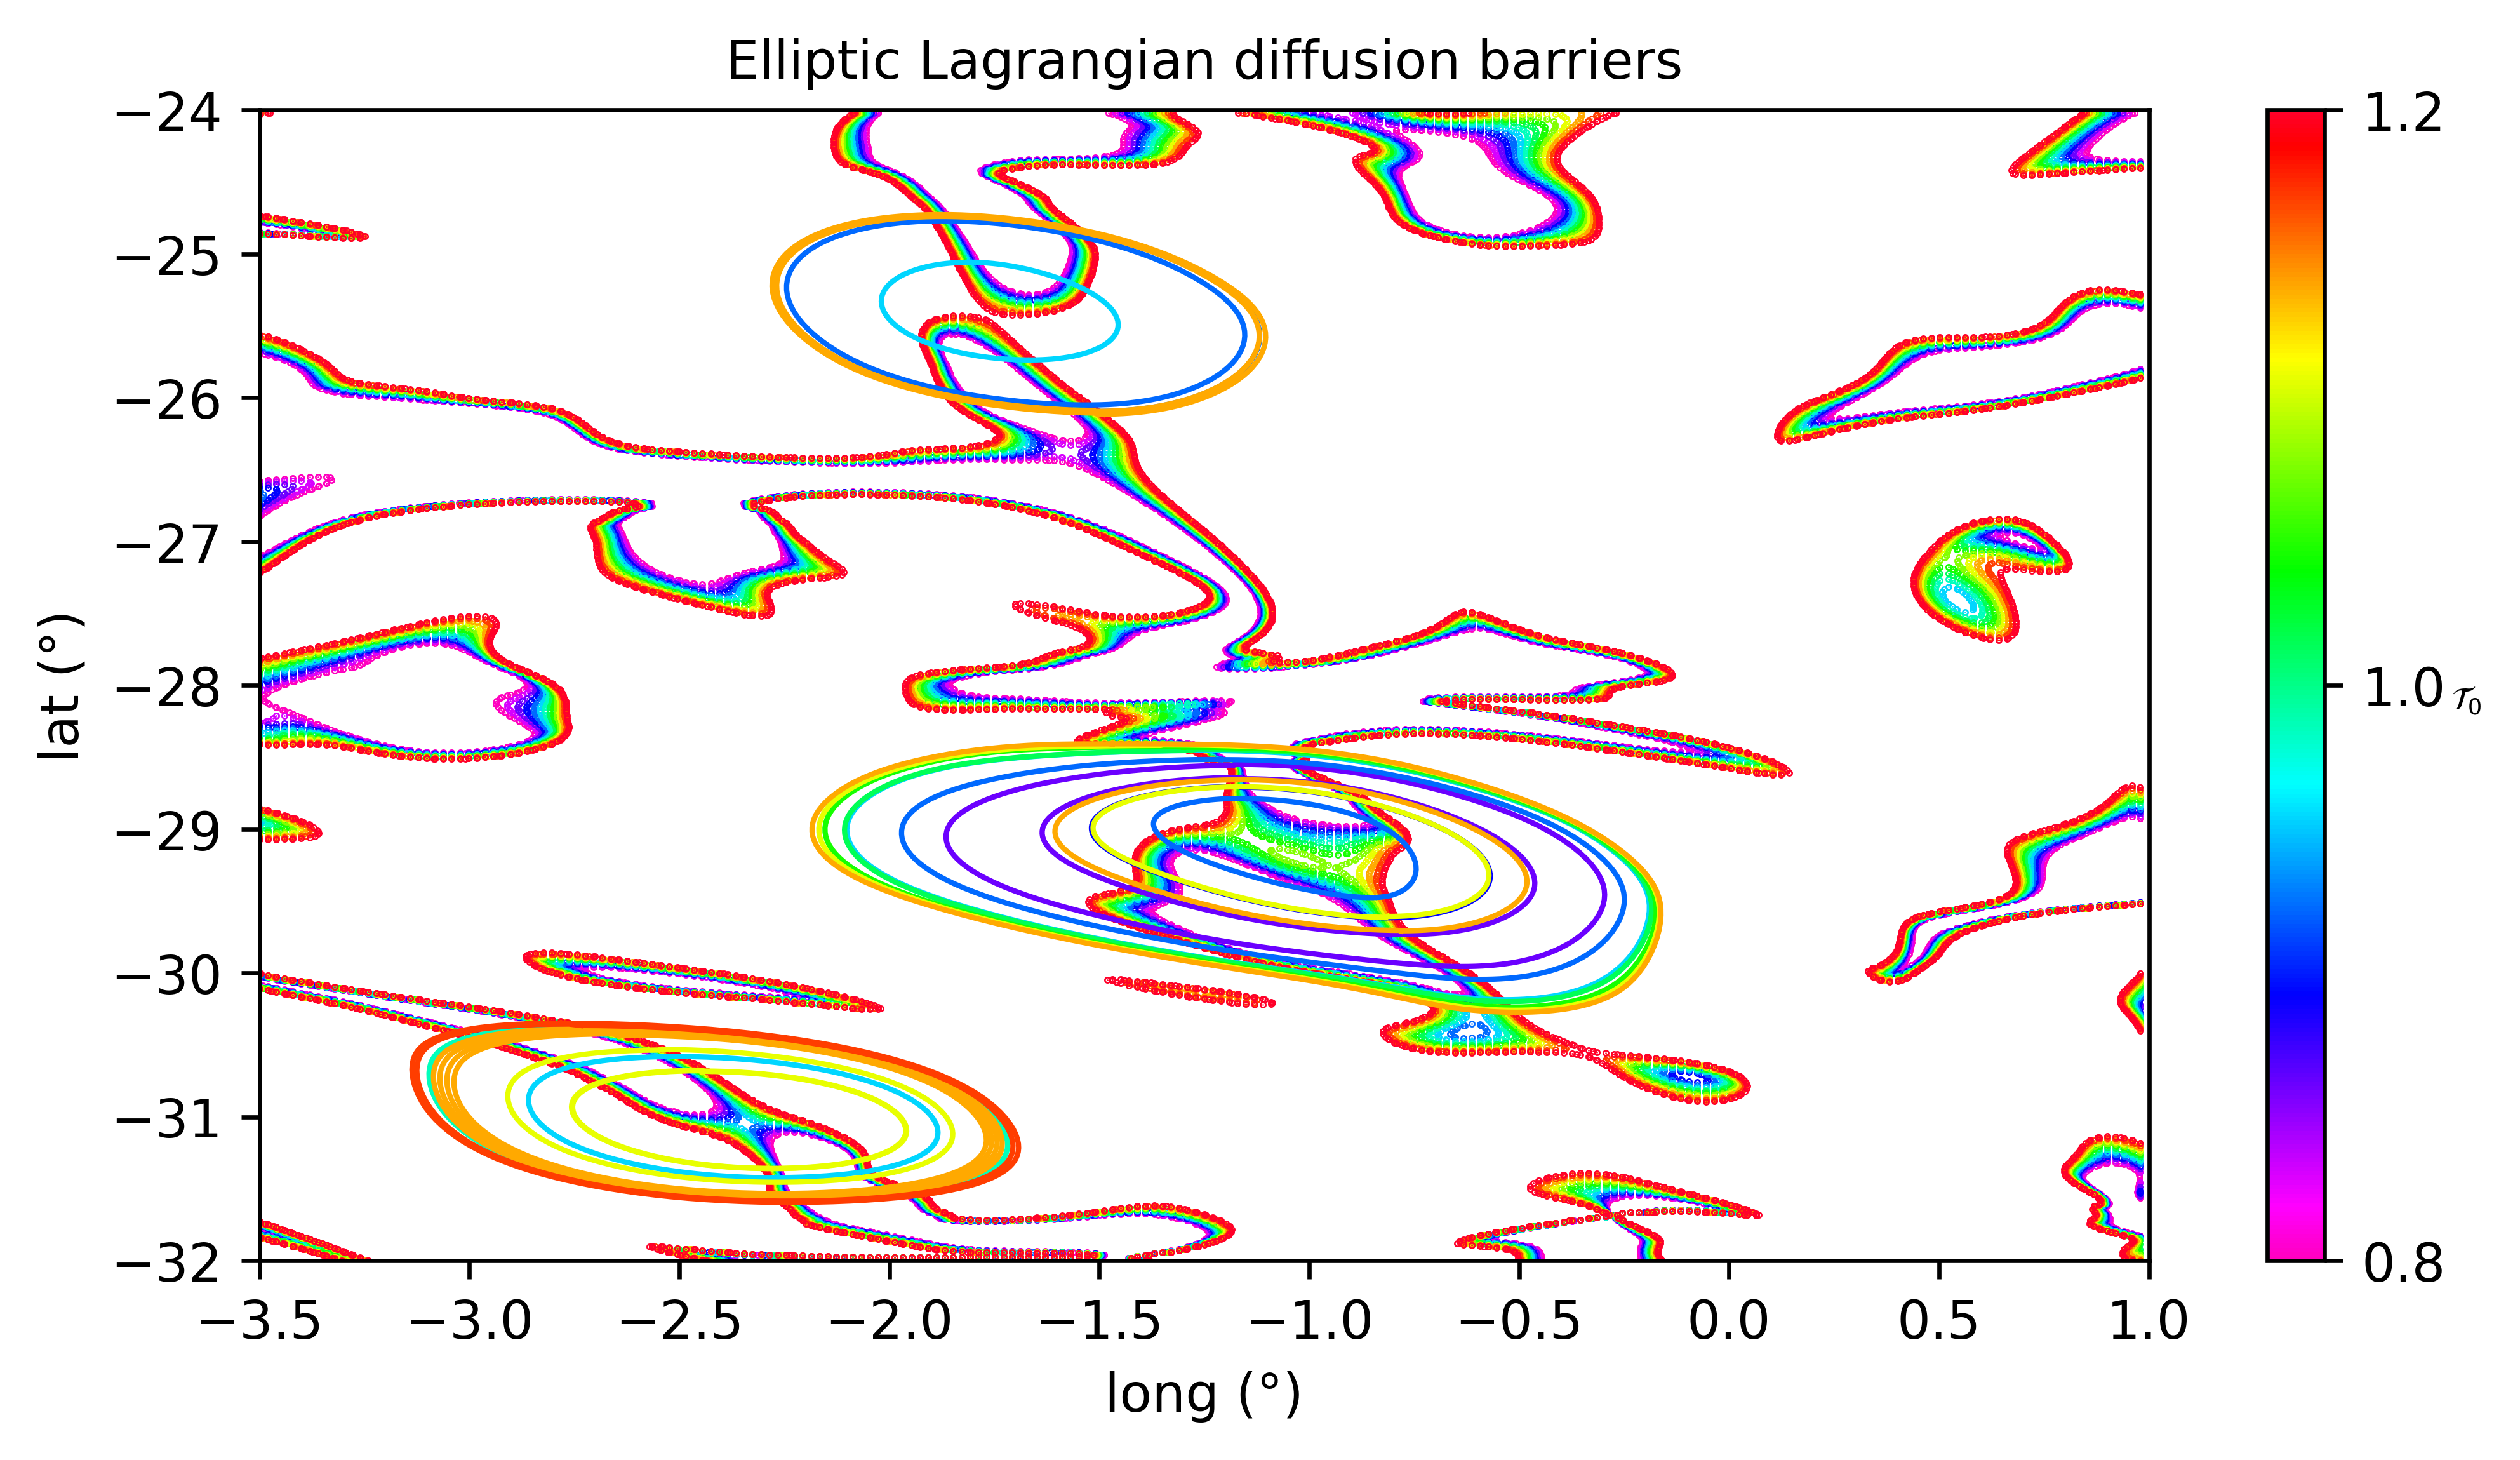

In [10]:
############################################ PLOT RESULTS ############################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=T0_range.min(), vmax=T0_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic LDB and plot
for i in range(len(Elliptic_LDB)):
    
    # Plot initial conditions
    ax.scatter(Elliptic_LDB[i][2][0], Elliptic_LDB[i][2][1], color=cmap.to_rgba(T0_range[i]), s = 0.1)
    
    # Plot elliptic LDB
    if Elliptic_LDB[i][0] is not None:
        for j in range(len(Elliptic_LDB[i][0])):
            if Elliptic_LDB[i][0][j] is not None:
                ax.plot(Elliptic_LDB[i][0][j], Elliptic_LDB[i][1][j], c=cmap.to_rgba(T0_range[i]), linewidth = 1)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[T0_range.min(), 1, 1.5, T0_range.max()])
cbar.ax.set_ylabel(r'$ \mathcal{T}_0 $', rotation = 0, fontsize = 6)

# Title
ax.set_title("Elliptic Lagrangian diffusion barriers", fontsize = 10)
plt.show();

The colored (closed) curves indicate elliptic Lagrangian diffusion barriers with constant transport density $ \mathcal{T}_0 $. The colored dots indicate the initial conditions depending on $ \mathcal{T}_0 $.

# Elliptic Lagrangian diffusion barriers on DBS

In [11]:
# add DBS folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/DiffusionBarriers/DBS")

# Import function for computing Diffusion Barrier Sensitivity
from ipynb.fs.defs.DBS import _DBS

# import function which extracts outermost elliptic LDB for each family of elliptic LDB
from ipynb.fs.defs.find_outermost_closed_curve import find_outermost_closed_curve

# find outermost elliptic LDB in each family of elliptic LDB
x_outermost_elliptic_LDB, y_outermost_elliptic_LDB, T0_outermost_elliptic_LDB = find_outermost_closed_curve(Elliptic_LDB, T0_range)

# initialize DBS
log_DBS = CD[0,0,:,:].copy()*np.nan

# compute DBS field
for i in range(CD.shape[2]):
    for j in range(CD.shape[3]):
        log_DBS[i, j] = np.log(_DBS(CD[:, :, i, j]))

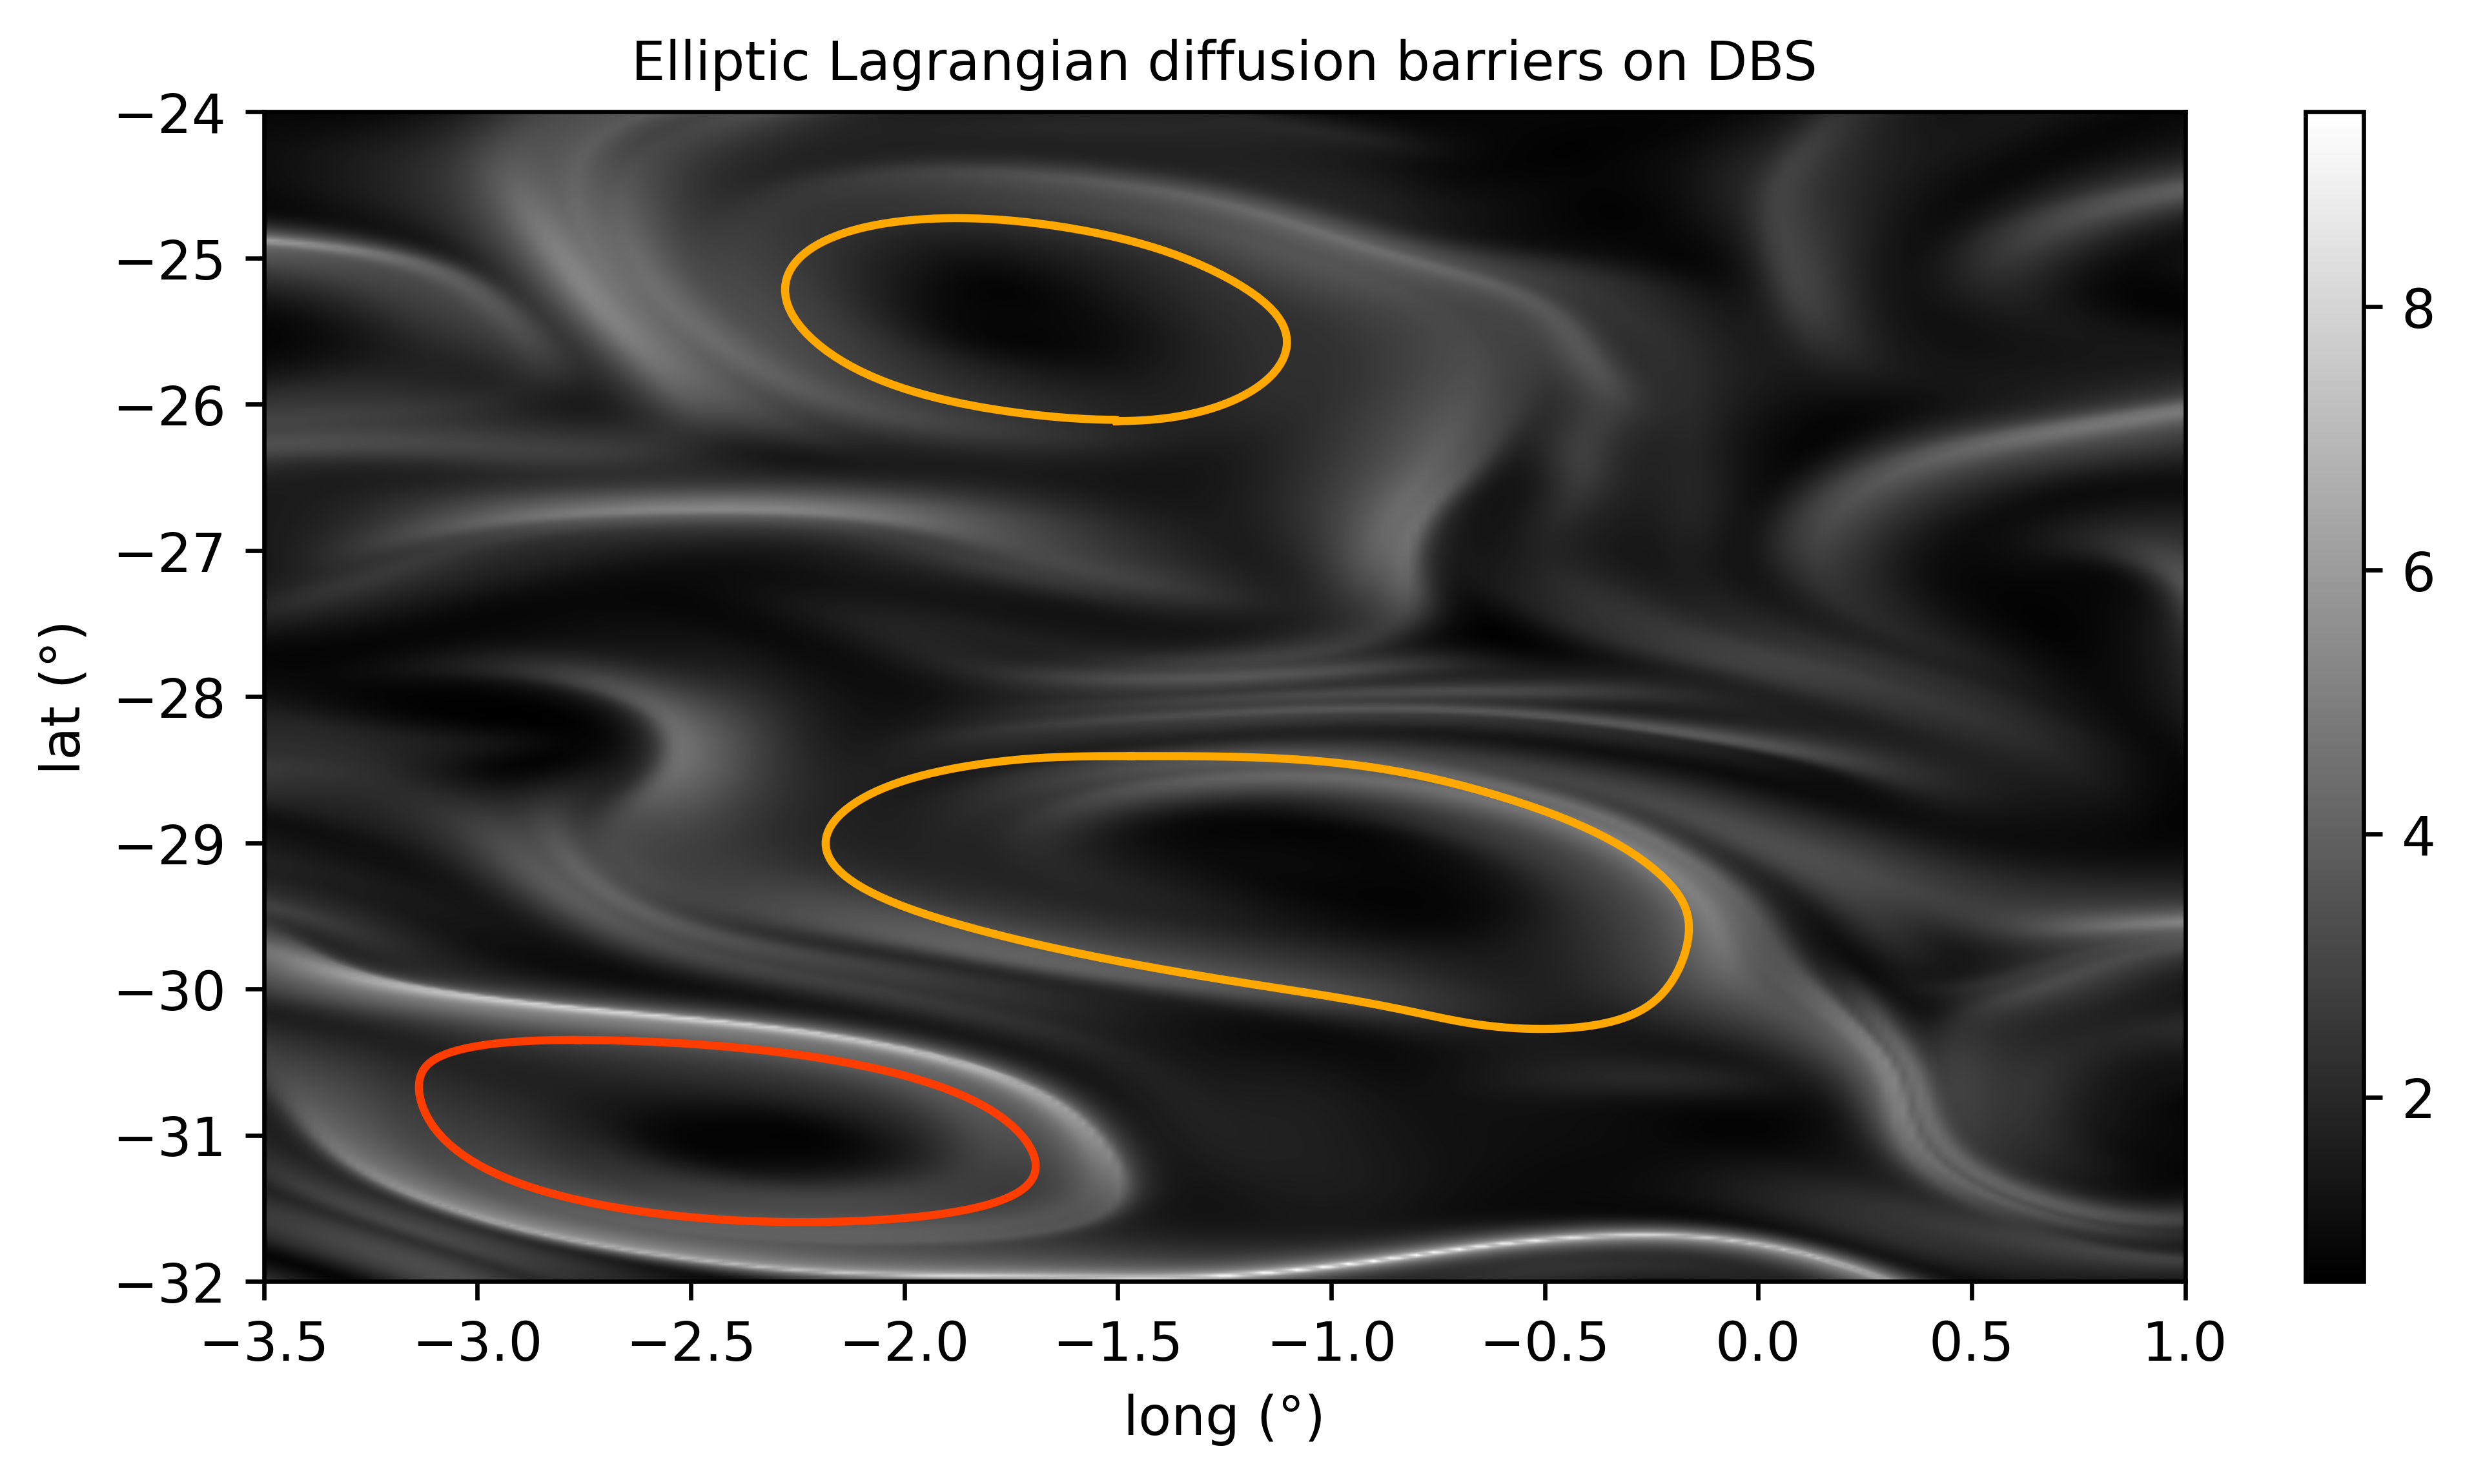

In [12]:
############################################ PLOT RESULTS ############################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=T0_range.min(), vmax=T0_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all outermost elliptic LDB and plot
for i in range(len(x_outermost_elliptic_LDB)):
    
    ax.plot(x_outermost_elliptic_LDB[i], y_outermost_elliptic_LDB[i], c=cmap.to_rgba(T0_outermost_elliptic_LDB[i]))
    
# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

cax = ax.contourf(X_domain, Y_domain, log_DBS, cmap = "gist_gray", levels = 600)

# Colorbar of log(DBS)
cbar = fig.colorbar(cax, ticks = np.arange(0, 16, 2))

# Title
ax.set_title("Elliptic Lagrangian diffusion barriers on DBS", fontsize = 10)

plt.show();

# References

[1] Haller, G., Karrasch, D., & Kogelbauer, F. (2018). Material barriers to diffusive and stochastic transport. Proceedings of the National Academy of Sciences, 115(37), 9074-9079.

[2] Notebook 8.1.4 in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.